In [1]:
# Real life data

import logging
import threading
import itertools
import pandas as pd  
import numpy as np  
import json
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import seaborn as seabornInstance
from sqlalchemy import Column, Integer, String, Float, DateTime, Boolean, func
from iotfunctions import base
from iotfunctions import bif
from iotfunctions import entity
from iotfunctions import metadata
from iotfunctions.metadata import EntityType
from iotfunctions.db import Database
from iotfunctions.dbtables import FileModelStore
from iotfunctions.enginelog import EngineLogging
from iotfunctions import estimator
from iotfunctions.ui import (UISingle, UIMultiItem, UIFunctionOutSingle,
                 UISingleItem, UIFunctionOutMulti, UIMulti, UIExpression,
                 UIText, UIStatusFlag, UIParameters)
from mmfunctions.anomaly import (SaliencybasedGeneralizedAnomalyScore, SpectralAnomalyScore,
                 FFTbasedGeneralizedAnomalyScore, GeneralizedAnomalyScore, KMeansAnomalyScore,
                 SaliencybasedGeneralizedAnomalyScoreV2, FFTbasedGeneralizedAnomalyScoreV2, 
                 KMeansAnomalyScoreV2)          
from mmfunctions.customer import UnrollData
import datetime as dt
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

EngineLogging.configure_console_logging(logging.INFO)
import numpy as np
import pandas as pd
import sklearn
from sklearn.covariance import MinCovDet

In [2]:
db_schema=None
class DatabaseDummy:
    tenant_id = '###_IBM_###'
    db_type = 'db2'
    model_store = FileModelStore()
    def _init(self):
        return

db = DatabaseDummy()
        
print (db.tenant_id)

2021-03-04T10:27:37.482 INFO iotfunctions.dbtables.__init__ Init FileModelStore with path: 
###_IBM_###


In [3]:
filename = "./IOT_SHADOW_PUMP_DE_GEN5_202102231533.csv"
dff = pd.read_csv(filename, parse_dates=['EVT_TIMESTAMP'], comment='#')
dff.columns = dff.columns.str.lower()
# deal with string timestamp indices 

dff['evt_timestamp'] = pd.to_datetime(dff['evt_timestamp'], format="%Y-%m-%d-%H.%M.%S.%f")
          
df_clean = dff.drop(columns=['devicetype','logicalinterface_id','eventtype','format',
                             'rcv_timestamp_utc','updated_utc']).set_index(['deviceid','evt_timestamp'])
df_i = df_clean.dropna()

2021-03-04T10:27:58.239 INFO numexpr.utils._init_num_threads Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2021-03-04T10:27:58.240 INFO numexpr.utils._init_num_threads NumExpr defaulting to 8 threads.


In [6]:
from mmfunctions.bif import (SeasonalDecompose, StateTimePreparation)
# hack - do not store model in db2
old_model_store = db.model_store
db.model_store = FileModelStore()

# Now run the anomaly functions as if they were executed in a pipeline
EngineLogging.configure_console_logging(logging.DEBUG)
jobsettings = { 'db': db, 
               '_db_schema': 'public', 'save_trace_to_file' : True}

sdcii = SeasonalDecompose('power', 12, np.nan, 'power_trend')
#sdcii = StateTimePreparation('power', '>4', 'power_trans')
et = sdcii._build_entity_type(columns = [Column('speed',Float())], **jobsettings)
sdcii._entity_type = et
sdcii.execute_by = ['deviceid']
df_i = sdcii.execute(df=df_i)

db.model_store = old_model_store
df_i.describe()

2021-03-04T10:29:26.137 INFO iotfunctions.dbtables.__init__ Init FileModelStore with path: 
2021-03-04T10:29:26.140 DEBUG iotfunctions.enginelog.configure_console_logging Console logging has been configured. Level = 10
2021-03-04T10:29:26.143 INFO mmfunctions.bif.__init__ SeasonalDecompose _init
2021-03-04T10:29:26.144 DEBUG iotfunctions.metadata.__init__ Initializing new entity type using iotfunctions 0.0.1
2021-03-04T10:29:26.144 DEBUG iotfunctions.util.__init__ Starting trace
2021-03-04T10:29:26.145 DEBUG iotfunctions.util.__init__ Trace name: auto_trace_test_entity_for_SeasonalDecompose_20210304092926
2021-03-04T10:29:26.145 DEBUG iotfunctions.util.__init__ auto_save None
2021-03-04T10:29:26.145 DEBUG iotfunctions.util.categorize_args categorizing arguments
2021-03-04T10:29:26.146 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2021-03-04T10:29:26.146 DEBUG iotfunctions

2021-03-04T10:33:27.114 INFO mmfunctions.bif._calc kexecute SeasonalDecompose
MultiIndex([('04714B60382B', '2021-02-16 11:15:11.088000'),
            ('04714B60382B', '2021-02-16 11:15:31.088000'),
            ('04714B60382B', '2021-02-16 11:15:51.088000'),
            ('04714B60382B', '2021-02-16 11:16:11.088000'),
            ('04714B60382B', '2021-02-16 11:16:31.088000'),
            ('04714B60382B', '2021-02-16 11:20:11.127000'),
            ('04714B60382B', '2021-02-16 11:20:31.127000'),
            ('04714B60382B', '2021-02-16 11:20:51.127000'),
            ('04714B60382B', '2021-02-16 11:21:11.127000'),
            ('04714B60382B', '2021-02-16 11:21:31.127000'),
            ...
            ('04714B60382B', '2021-02-23 11:06:41.500000'),
            ('04714B60382B', '2021-02-23 11:07:01.500000'),
            ('04714B60382B', '2021-02-23 11:07:21.500000'),
            ('04714B60382B', '2021-02-23 11:07:41.500000'),
            ('04714B60382B', '2021-02-23 11:08:01.500000'),
      

Power trend evt_timestamp
2020-12-23 22:16:11.170    0.004841
2020-12-23 22:16:31.170    0.004840
2020-12-23 22:16:51.170    0.004839
Name: power, dtype: float64
Power trend deviceid      evt_timestamp          
04714B606390  2020-12-23 22:16:11.170    0.004841
              2020-12-23 22:16:31.170    0.004840
              2020-12-23 22:16:51.170    0.004839
Name: power_trend, dtype: float64
2021-03-04T10:34:55.067 INFO mmfunctions.bif._calc Exit SeasonalDecompose


,rms_x,rms_z,rms_y,power,speed,__intermediate1__,__intermediate2__,power_trend
count,861165.000000,861165.000000,861165.000000,861165.000000,861165.000000,861165.000000,8.611650e+05,8.611650e+05
mean,0.076957,0.293800,0.783084,5.998290,634.447573,-0.000005,1.606126e+09,5.957054e+00
std,0.087492,0.388257,0.427317,8.171752,579.508187,0.035479,6.004732e+06,8.118448e+00
min,0.004989,0.010101,0.007598,0.000000,0.000000,-1.000000,1.595153e+09,-5.070448e+00
25%,0.015818,0.043151,0.956483,0.000000,0.000000,0.000000,1.599905e+09,2.887287e-08
50%,0.045733,0.097804,1.042373,1.742200,1059.000000,0.000000,1.608412e+09,1.737856e+00
75%,0.084654,0.165243,1.044580,18.661800,1147.000000,0.000000,1.611243e+09,1.871243e+01
max,0.580223,1.044346,1.078255,43.012794,3600.000000,1.000000,1.614083e+09,1.983195e+01


In [7]:
df_i

rms_x     rms_z     rms_y   power  \
deviceid     evt_timestamp                                                   
04714B601096 2020-07-19 10:15:05.144  0.095934  0.059262  0.956817  1.7270   
             2020-07-19 10:15:25.144  0.093044  0.060636  0.957341  1.7298   
             2020-07-19 10:15:45.144  0.090586  0.062215  0.956682  1.7298   
             2020-07-19 10:19:25.165  0.091974  0.063664  0.956705  1.7262   
             2020-07-19 10:19:45.165  0.094407  0.061748  0.956924  1.7262   
...                                        ...       ...       ...     ...   
04714B606390 2021-02-23 10:19:45.813  0.018351  1.022032  0.021606  0.0000   
             2021-02-23 10:20:05.813  0.018063  1.021309  0.021091  0.0000   
             2021-02-23 10:20:25.813  0.018158  1.022185  0.021522  0.0000   
             2021-02-23 10:24:10.322  0.018733  1.020812  0.021202  0.0000   
             2021-02-23 10:24:30.322  0.018419  1.021242  0.021592  0.0000   

                                       speed  __intermediate1__  \
deviceid     evt_timestamp                                        
04714B601096 2020-07-19 10:15:05.144  1059.0                 -1   
             2020-07-19 10:15:25.144  1059.0                  0   
             2020-07-19 10:15:45.144  1059.0                  0   
             2020-07-19 10:19:25.165  1059.0                  0   
             2020-07-19 10:19:45.165  1059.0                  0   
...                                      ...                ...   
04714B606390 2021-02-23 10:19:45.813     0.0                  0   
             2021-02-23 10:20:05.813     0.0                  0   
             2021-02-23 10:20:25.813     0.0                  0   
             2021-02-23 10:24:10.322     0.0                  0   
             2021-02-23 10:24:30.322     0.0                  0   

                                      __intermediate2__    power_trans  \
deviceid     evt_timestamp                                               
04714B601096 2020-07-19 10:15:05.144         1595153705  -1,1595153705   
             2020-07-19 10:15:25.144         1595153725   0,1595153725   
             2020-07-19 10:15:45.144         1595153745   0,1595153745   
             2020-07-19 10:19:25.165         1595153965   0,1595153965   
             2020-07-19 10:19:45.165         1595153985   0,1595153985   
...                                                 ...            ...   
04714B606390 2021-02-23 10:19:45.813         1614075585   0,1614075585   
             2021-02-23 10:20:05.813         1614075605   0,1614075605   
             2021-02-23 10:20:25.813         1614075625   0,1614075625   
             2021-02-23 10:24:10.322         1614075850   0,1614075850   
             2021-02-23 10:24:30.322         1614075870   0,1614075870   

                                      power_trend  
deviceid     evt_timestamp                         
04714B601096 2020-07-19 10:15:05.144     1.733648  
             2020-07-19 10:15:25.144     1.733648  
             2020-07-19 10:15:45.144     1.733647  
             2020-07-19 10:19:25.165     1.733643  
             2020-07-19 10:19:45.165     1.733642  
...                                           ...  
04714B606390 2021-02-23 10:19:45.813     0.008014  
             2021-02-23 10:20:05.813     0.008015  
             2021-02-23 10:20:25.813     0.008016  
             2021-02-23 10:24:10.322     0.008030  
             2021-02-23 10:24:30.322     0.008031  

[861165 rows x 9 columns]

deviceid
04714B601096    AxesSubplot(0.125,0.125;0.775x0.755)
04714B603408    AxesSubplot(0.125,0.125;0.775x0.755)
04714B6036B1    AxesSubplot(0.125,0.125;0.775x0.755)
04714B6037F8    AxesSubplot(0.125,0.125;0.775x0.755)
04714B60382B    AxesSubplot(0.125,0.125;0.775x0.755)
04714B604101    AxesSubplot(0.125,0.125;0.775x0.755)
04714B60553A    AxesSubplot(0.125,0.125;0.775x0.755)
04714B605699    AxesSubplot(0.125,0.125;0.775x0.755)
04714B606390    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

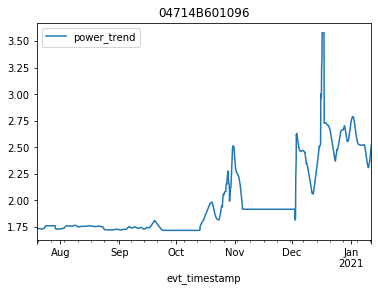

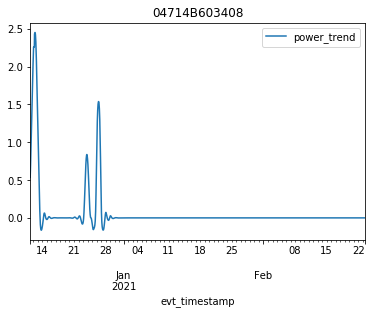

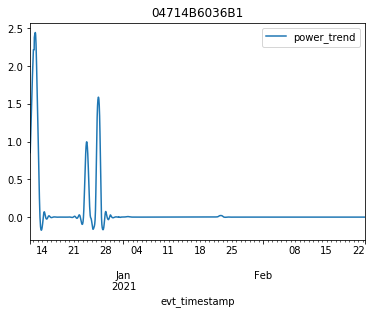

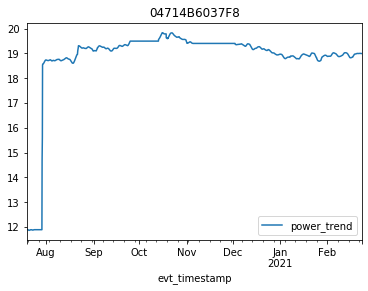

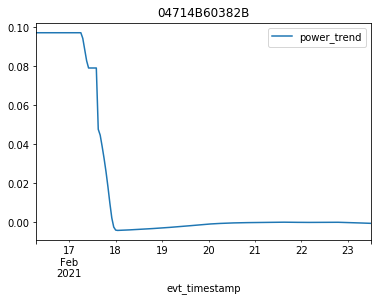

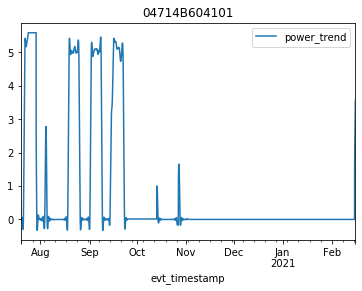

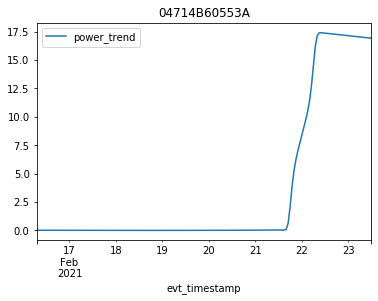

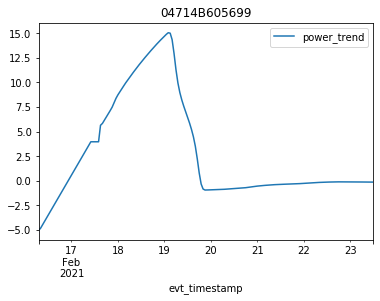

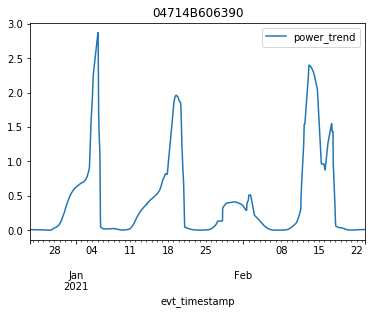

In [50]:
df_i[['power_trend']].groupby(['deviceid']).apply(lambda group:
    group.reset_index(level=0).resample('H').mean().ffill().plot(title=group.index[0][0]))

